# LAB 1

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.optimize import root as get_root
from sklearn.cluster import DBSCAN, KMeans
from numba import njit
from sympy import *

plt.rcParams["figure.figsize"] = [15, 7]

# Task 1

In [27]:
interval = (2.8, 4)  # start, end
accuracy = 0.00001
reps = 1000  # number of repetitions
a = 1e-2

lims = []
lims2 = [] # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4

for r in tqdm(np.arange(*interval, accuracy)):
    temp_lims = []
    temp_lims2 = [] # initialize temp lists for storing data
    initial_val = np.random.rand()
    temp_lims.append(initial_val)
    temp_lims2.append(initial_val + perturbation(initial_val)) # creating the same initial condition as the perturbed version
    
    for i in range(reps-1):
        val = r*temp_lims[i]*(1-temp_lims[i])
        temp_lims.append(val)
        temp_lims2.append(val + perturbation(val)) # store values with perturbation
    
    lims.append(temp_lims)
    lims2.append(temp_lims2) # store temp lists in main lists
    
lims = np.array(lims)
lims2 = np.array(lims2)
lims.shape

100%|██████████| 120001/120001 [03:24<00:00, 587.91it/s]


(120001, 1000)

More optimized plotting

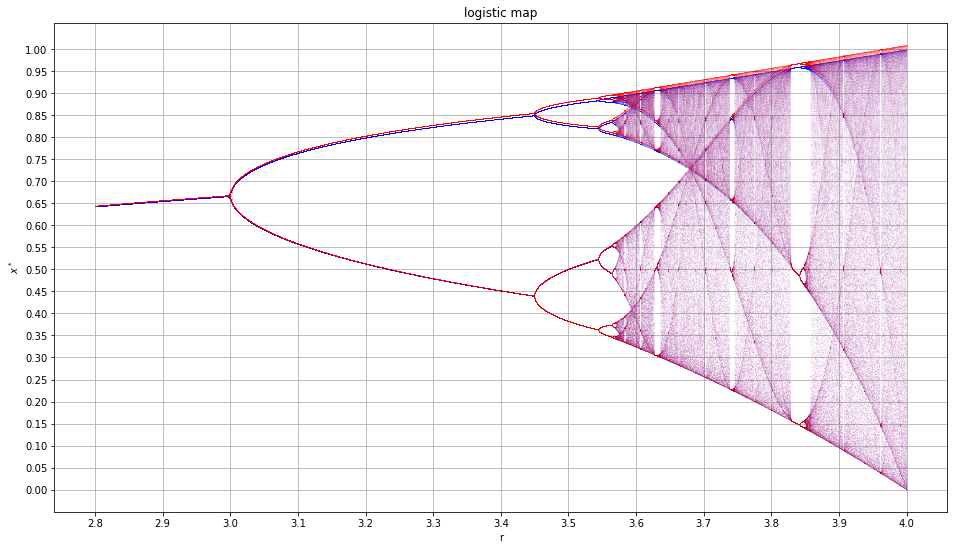

In [193]:
numtoplot = 10

fig, biax = plt.subplots(figsize=(16, 9))

# create arrays of x-coordinates and y-coordinates for unperturbed data
r_vals = np.arange(*interval, accuracy)
x_vals = lims[:, -numtoplot:]
r_broadcasted = np.broadcast_to(r_vals[:, None], (len(r_vals), numtoplot))
biax.plot(r_broadcasted.flatten(), x_vals.flatten(), 'b.', markersize=.02)

# create arrays of x-coordinates and y-coordinates for perturbed data
x2_vals = lims2[:, -numtoplot:]
biax.plot(r_broadcasted.flatten(), x2_vals.flatten(), 'r.', markersize=.02)

biax.set(xlabel='r', ylabel='$x^*$', title='logistic map')
plt.xticks(np.arange(*interval, 0.1))
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.grid()
#plt.legend()
#plt.show()
plt.savefig("logistic map (blue) - perturbed map (red)", bbox_inches="tight")

In [188]:
r, x = symbols("r, x")

f0 = r*x*(1-x)
f = r*x*(1-x)

for i in range(1, 3):
    f = f.subs(x, f0)
    f_num = lambdify([x, r], f - x)
    
    
#print(f)
FP = get_root(f_num, x0=np.linspace(0,1,10), args=(3.5,))["x"].round(5)
#np.unique(FP)
get_root(f_num, x0=np.linspace(0,1,10), args=(3.5,))

    fjac: array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])
     fun: array([ 0.00000000e+00,  2.04765008e-01, -5.48156150e-05,  2.04798591e-01,
       -8.09862163e-04, -7.30109487e-02,  7.84640517e-05,  4.45958818e-06,
       -7.15310506e-02, -8.90247345e-02])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last five Jacobian evaluations.'
    nfev: 154
     qtf: array([ 0.00000000e+00, -2.04765017e-01, -

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps.

The idea is to find the Lyapunov exponents of the Logistic map. 
These exponents will for most part be negative, this means that at the corresponding bifurcantion parameter r, the corresponding fixed point (FP) $x^{*}$ will be stable. 
The Lyapunov exponent will occationally appraoch zero, this phenomena means that the system is approaching to a transition phase, supercritical bifucation point. At this point $x^{*}=0$, new (real valued) FP will be created. It is essentially a manifold in $\mathcal{C}$ that moves and gets completely embedded as a subspace in $\mathcal{R}$, as a result, the previously complex FP can now be visualized as the real valued FP $x^{*}$.\
With the set of Lyapunov exponents for each $r$, we can determine a subspace $l$ that contains the Lyapunov exponents which are "sufficiently close" to zero. This subset will capture the nessesairly information of which $r$ the period of the map doubles. Let $A$ be the set where the elements represents the values $r_n$ at the supercritical bifurcation point. Then the first Feigenbaum constant $\alpha$ is given by 
$$
\alpha = \lim_{n \rightarrow \infty} \frac{a_{n-1} - a_{n-2}}{a_{n} - a_{n-1}}
$$
for $a_n \in A$.

## Finding the Lyapunov exponent

In [32]:
def diff(x, r): # Derivative of the Logistic map
    return r*(1 - 2*x)

# bifurcation parameters
R = np.arange(*interval, accuracy) 
L = np.zeros(len(R)) # Lyapunov exponent

for i, r in enumerate(R):
    # Finding the x for different iterations x_i=(x1, x2, ..., xn)_i
    x = lims[i] 
    # Computing the Lyapunov exponent for some different bifurcation parameters
    L[i] = np.log(np.abs(diff(x, r))).mean() 

L.shape

(120001,)

The figure below shows where the bifurcation occurs by finding the points of the Lyapunov exponents that is close to zero.

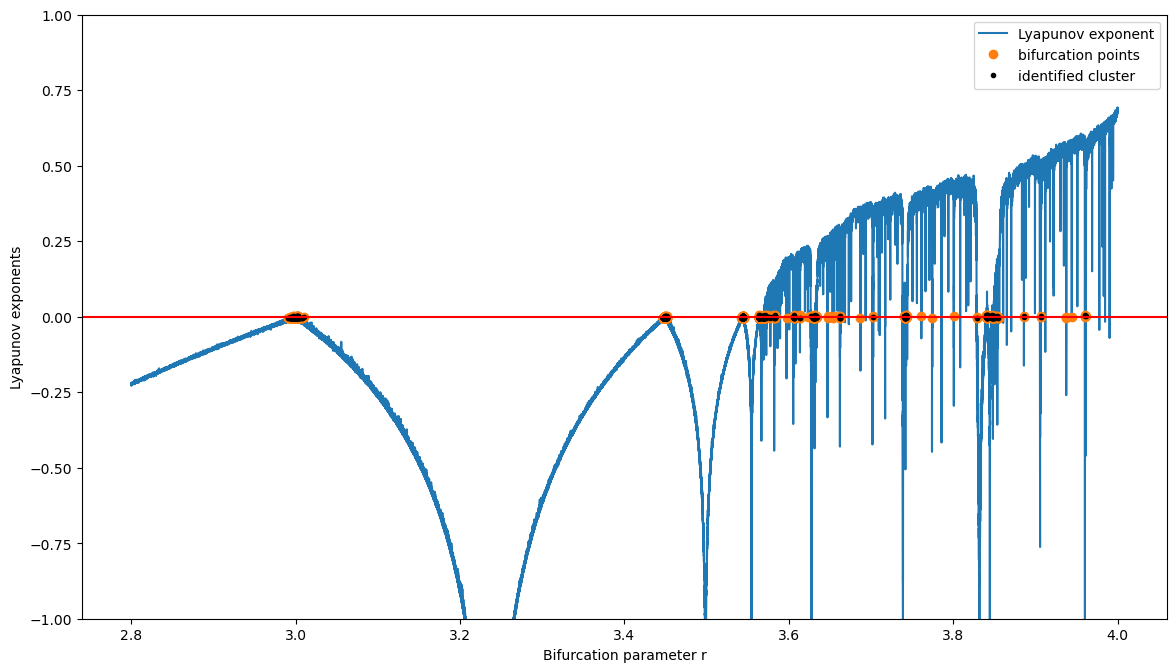

In [35]:
index = np.where(np.abs(L) <= 5e-3)[0]


plt.figure(figsize=(14,8), dpi=100)
plt.plot(R, L, label="Lyapunov exponent")
plt.plot(R[index], L[index], "o", label="bifurcation points")


X = np.concatenate([R[index][:,None],L[index][:,None]], axis=1)
cluster = DBSCAN(0.002, min_samples=2).fit(X)
#cluster = KMeans(13).fit(X)
plt.plot(*cluster.components_.T, "k.", label="identified cluster");

plt.ylim(-1, 1)
plt.axhline(0, color="red")
plt.ylabel("Lyapunov exponents")
plt.xlabel("Bifurcation parameter r")
plt.legend()
plt.show()

In [155]:
r, x = symbols("r, x")

f0 = r*x*(1-x)
f = r*x*(1-x)

for i in range(1, 2):
    f = f.subs(x, f0)
    f_num = lambdify([x, r], f - x)
    
    
#print(f)
get_root(f_num, x0=0.5, args=(3.1,))["x"]

array([0.55801413])

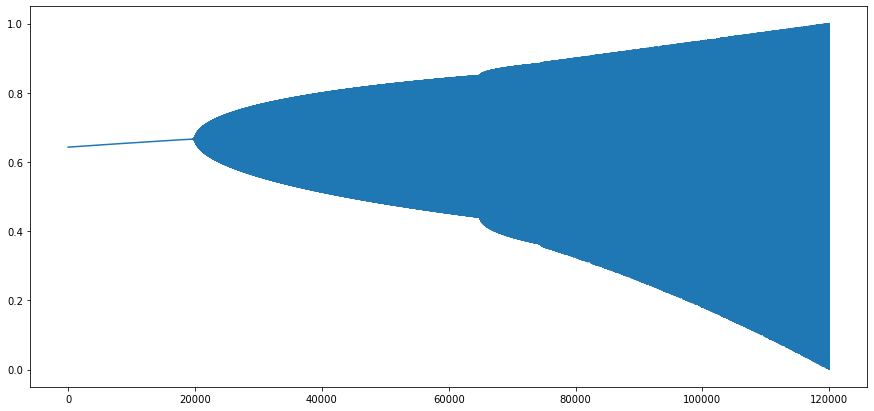

In [100]:
from scipy.signal import find_peaks


#plt.plot(lims.max(1), ".")

plt.plot(lims[:,-1])

## Finding the Lyapunov exponent that is close to zero

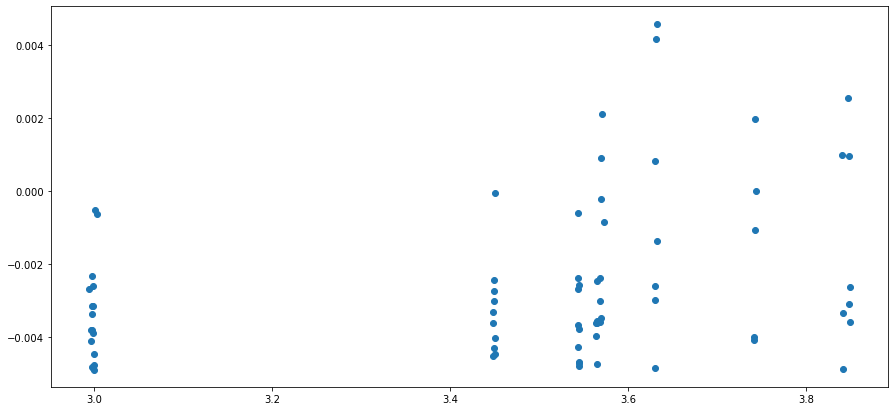

In [370]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

X = np.concatenate([R[index][:,None],L[index][:,None]], axis=1)
dbscan = DBSCAN(0.01)
dbscan.fit(X)

plt.plot(*dbscan.components_.T, "o");

# Task 3

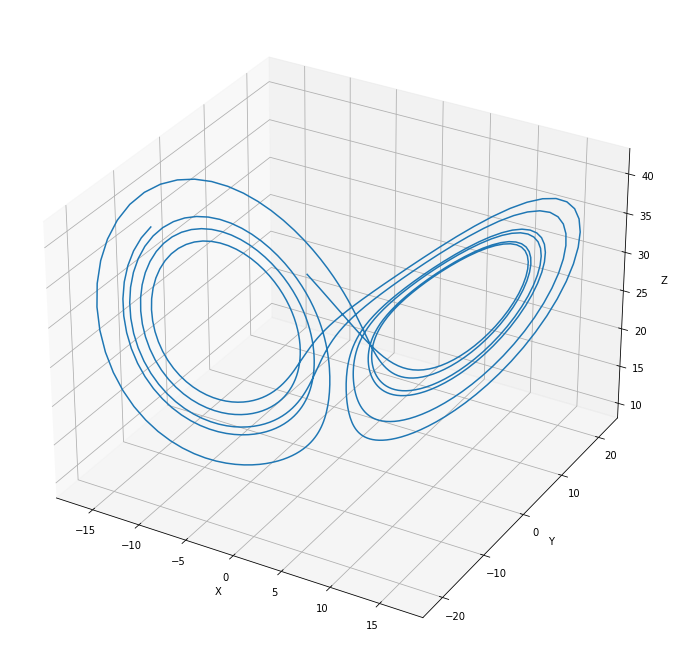

In [15]:
# plotting the solutions to the Lorentz system
def plot_array_3d(arr):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(*arr.T)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# runge-kutta fourth-order numerical integration
@njit
def rk4(func, tk, _yk, _dt=0.01):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)))
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)))
    f4 = func(tk + _dt, _yk + (f3 * _dt))

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

@njit
def lorenz(_t, _y, sigma=10, beta=(8 / 3), rho=28):
    """
    lorenz chaotic differential equation: dy/dt = f(t, y)
    _t: time tk to evaluate system
    _y: 3D state vector [x, y, z]
    sigma: constant related to Prandtl number
    beta: geometric physical property of fluid layer
    rho: constant related to the Rayleigh number
    return: [x_dot, y_dot, z_dot]
    """
    return np.array([
        sigma * (_y[1] - _y[0]),
        _y[0] * (rho - _y[2]) - _y[1],
        (_y[0] * _y[1]) - (beta * _y[2]),
    ])

dt = 0.01
time = np.arange(0.0, 8.0, dt)
state_history = []

yk = np.array([-7, 8, 26])

# iterate over time
for t in time:
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)
    
state_history = np.array(state_history)
plot_array_3d(state_history)

# Task 4
1. Choose some initial condition such that it is attracted by the Lorentz system.
2. Definition of Lyapunov exponent: 
$$\lambda = \frac{1}{n}\sum_{i=0}^{n-1}\ln{\abs{f'(x_i)}}$$. What happens when $n$ becomes big? Is $\lambda$ positive or negative? What does it mean?

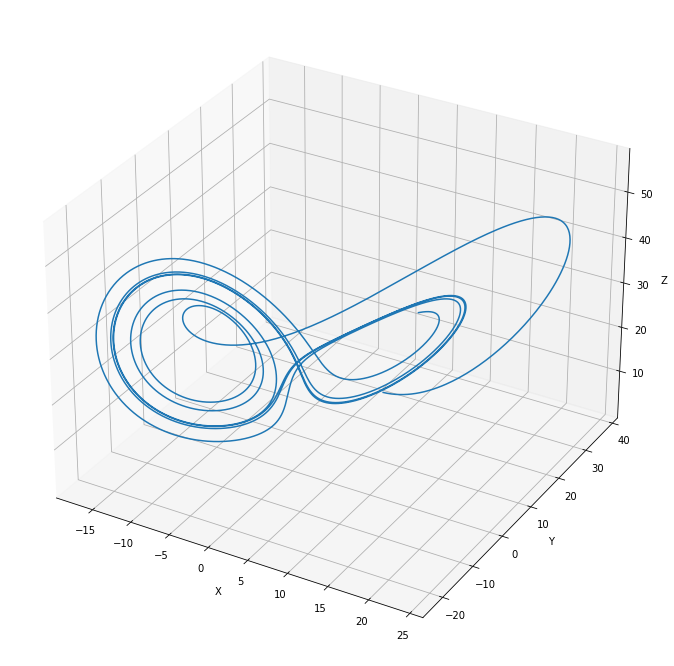

In [26]:
eps = 0.01
x0 = 1 + eps
y0 = 28*x0 - 3/8*x0**3
z0 = 3/8*x0**2

yk = np.array([x0, y0, z0])

dt = 0.001
time = np.arange(0.0, 8.0, dt)
state_history = []

# iterate over time
for t in time:
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)
    
state_history = np.array(state_history)
plot_array_3d(state_history)